<h1>Procesamiento de datos a gran escala</h1>

<p><strong>Objetivo: </strong> El objetivo de este cuaderno es aplicar el algoritmo de clustering a un conjunto de datos sencillos. </p>

<h2>Clustering</h2>

<h2>Indice</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ul>
  <li>Cargar los Datos</li>
  <li>Aplicando Algortimo K-Medias</li>
</ul>

Tiempo estimado: <strong>10 min</strong>

</div>
<hr>

<h3>Cargar los datos</h3>

Para este ejercicio se estará utilizando el conjunto de datos Iris, la cual es una fuente en línea en formato CSV (valores separados por coma).
<p> Este set de datos posee diferentes medidas sobre la planta Iris y es famosamente utilizado como ejemplo en analítica de datos:
  </p>
Se utiliza este conjunto para ejemplificar la creación de clusters:

<ul>
  <li>descripción: <a href="https://archive.ics.uci.edu/ml/datasets/Iris" target="_blank">https://archive.ics.uci.edu/ml/datasets/Iris</a></li>
  <li>fuente de datos: <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data" target="_blank">https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data</a></li>
    <li>tipo de datos: csv</li>

Se va a utilizar la librería Pandas de Python para realizar la lectura de archivos. Se cargan los datos, se agregan cabeceras y se muestra el resultado:

In [875]:
#!pip install findspark
#!pip install pyspark

In [876]:
import warnings
warnings.filterwarnings('ignore')

In [877]:
import findspark
findspark.init()
from pyspark import SparkConf
from pyspark.sql import SparkSession, SQLContext

import sys

In [878]:
# Configuración local
configuraDierickBrochero = (
    SparkConf()
        .set("spark.scheduler.mode", "FAIR")
        .set("spark.executor.memory", "10G")
        .set("spark.executor.cores", "1")
        .set("spark.cores.max", "9")
        .set("spark.ui.port", "4040")
        .setMaster("local[*]")  # <---- Spark local usando todos los cores
        .setAppName("hpcsparkDierickBrochero")
)

# Crear sesión Spark local
sparkDierickBrochero = (
    SparkSession
        .builder
        .config(conf=configuraDierickBrochero)
        .getOrCreate()
)

sqlContext = SQLContext(sparkDierickBrochero.sparkContext)

sparkDierickBrochero

In [879]:
# Leer datos desde archivo CSV
import wget
from pyspark.sql.types import StructType, StructField, FloatType, StringType

url_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
local_path ="/Users/dierickbr/Library/CloudStorage/OneDrive-PontificiaUniversidadJaveriana/Computacion Alto desempeño/Datos"
wget.download(url_path,local_path)

schema = StructType([StructField("sepal_length", FloatType(), True),
                     StructField("sepal_width",  FloatType(), True),
                     StructField("petal_length", FloatType(), True),
                     StructField("petal_width",  FloatType(), True),
                     StructField("Species",        StringType(), True)])


df00 = sparkDierickBrochero.read.format("csv").option("header", "false").schema(schema).load(local_path)

df00.show(5)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows


In [880]:
df00.printSchema()

root
 |-- sepal_length: float (nullable = true)
 |-- sepal_width: float (nullable = true)
 |-- petal_length: float (nullable = true)
 |-- petal_width: float (nullable = true)
 |-- Species: string (nullable = true)



In [881]:
from pyspark.sql.functions import col, count, when, isnan

#df00.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

numeric_cols = [c for c, t in df00.dtypes if t in ('float', 'double')]
all_cols = df00.columns

exprs = [
    count(when(col(c).isNull() | (isnan(c) if c in numeric_cols else False), c)).alias(c)
    for c in all_cols
]

df00.select(exprs).show()

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|Species|
+------------+-----------+------------+-----------+-------+
|           0|          0|           0|          0|      0|
+------------+-----------+------------+-----------+-------+




### Aplicar Indexador a Columna "Species"

In [882]:
from pyspark.ml.feature import StringIndexer
# StringIndexer Initialization
indexer = StringIndexer(inputCol="Species", outputCol="Species_Indexed")
indexerModel = indexer.fit(df00)

# Transform the DataFrame using the fitted StringIndexer model
df01 = indexerModel.transform(df00)
df01.show()

+------------+-----------+------------+-----------+-----------+---------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|Species_Indexed|
+------------+-----------+------------+-----------+-----------+---------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|            0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|            0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|            0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|            0.0|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|            0.0|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|            0.0|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|            0.0|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.1|         1.5| 

In [883]:
df01.select('Species').distinct().collect()

[Row(Species='Iris-virginica'),
 Row(Species='Iris-setosa'),
 Row(Species='Iris-versicolor')]

<h3>Aplicar Algortimo K-Medias</h3>

Seleccione solo las columnas numéricas:

In [884]:
df02 = df00[["sepal_length","sepal_width","petal_length","petal_width"]]
df02.show(5)

+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|         5.1|        3.5|         1.4|        0.2|
|         4.9|        3.0|         1.4|        0.2|
|         4.7|        3.2|         1.3|        0.2|
|         4.6|        3.1|         1.5|        0.2|
|         5.0|        3.6|         1.4|        0.2|
+------------+-----------+------------+-----------+
only showing top 5 rows


### Formatear los datos usando Vector Assembler en los vectores los cuales serán usados como "features"

In [885]:
from pyspark.ml.feature import VectorAssembler

In [886]:
assembler = VectorAssembler(inputCols = df02.columns, outputCol='features')
df_datos = assembler.transform(df00)


### Escalar los datos

In [887]:
from pyspark.ml.feature import StandardScaler

escalador = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

In [888]:
# Compute summary statistics by fitting the StandardScaler
modeloEscalado = escalador.fit(df_datos)

# Normalize each feature to have unit standard deviation.
df_datos = modeloEscalado.transform(df_datos)

df_datos.show(5)

+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|            features|      scaledFeatures|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.09999990463256...|[-0.8991789060725...|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.90000009536743...|[-1.1411101906136...|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.69999980926513...|[-1.3830420519644...|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.59999990463256...|[-1.5040076942349...|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.5999999046...|[-1.0201445483430...|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
only showing top 5 rows


### Encontrar el número de clusters usando Silhouette Score

In [889]:
#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]

evaluador = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')

for i in range(2,10):
    kmeans=KMeans(featuresCol='scaledFeatures', k=i)
    KMeans_fit=kmeans.fit(df_datos)
    output = KMeans_fit.transform(df_datos)   
    score = evaluador.evaluate(output)   
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

Silhouette Score for k = 2 is 0.7727933596456382
Silhouette Score for k = 3 is 0.6523362286529399
Silhouette Score for k = 4 is 0.5885112761481718
Silhouette Score for k = 5 is 0.5024428880222488
Silhouette Score for k = 6 is 0.5369102658873066
Silhouette Score for k = 7 is 0.5366346467443041
Silhouette Score for k = 8 is 0.49085966173747975
Silhouette Score for k = 9 is 0.48985868329551785


### Visualización de silhouette scores

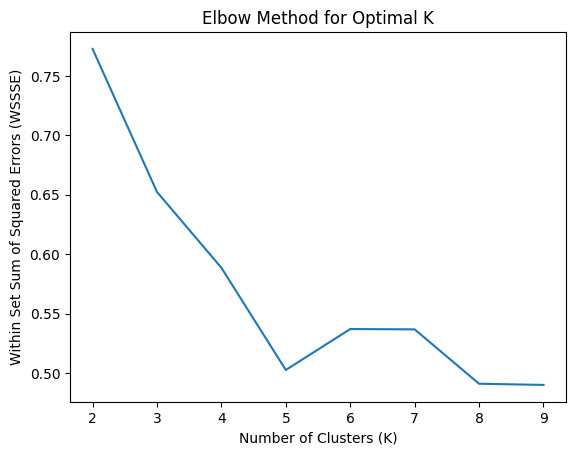

In [890]:
import matplotlib.pyplot as plt

plt.plot(range(2,10),silhouette_score)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.show()

¿Cúal k seleccionar? ¿Son satisfactorios los resultados de las diferentes k? 
- Se selecciona k=3 (¿porqué?)
- Compare los resultados para k=4, k=6, k=8

### Entrenar el modelo

In [891]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd

# --- 1. Definiciones y Setup ---
k_values = [3, 4, 6, 8]
seed_value = 42
metrics_summary = []

# IMPORTANTE: Definición del Evaluador para resolver el NameError
evaluator = ClusteringEvaluator(
    featuresCol="scaledFeatures", 
    predictionCol="cluster",
    metricName="silhouette", 
    distanceMeasure="squaredEuclidean"
)

# --- 2. Bucle de Entrenamiento y Evaluación ---
for k in k_values:
    # Crear y entrenar KMeans
    kmeans = KMeans(
        featuresCol="scaledFeatures", 
        predictionCol="cluster", 
        k=k, 
        seed=seed_value
    )
    modelo = kmeans.fit(df_datos)
    
    predictions = modelo.transform(df_datos)
    
    # Calcular Métrica WSSSE (trainingCost)
    wssse = modelo.summary.trainingCost
    
    # Calcular Silhouette Score (evaluator.evaluate)
    silhouette = evaluator.evaluate(predictions)
    
    # Guardar resultados
    metrics_summary.append({
        "k": k,
        "WSSSE": wssse,
        "Silhouette Score": silhouette
    })

# Mostrar resultados
df_results = pd.DataFrame(metrics_summary).sort_values(by="Silhouette Score", ascending=False)
print("\n--- Resumen Final de Métricas ---")
print(df_results)


--- Resumen Final de Métricas ---
   k       WSSSE  Silhouette Score
0  3  283.273866          0.647111
1  4  229.035984          0.594141
3  8  127.689240          0.553736
2  6  163.297824          0.534108


In [892]:
#kmeans = KMeans(k=4, featuresCol="scaledFeatures", predictionCol="cluster")
#kmeans_model = kmeans.fit(df_datos)

### Evaluar el modelo k=3 Within Set Sum of Squared Errors (WSSSE) metric

In [893]:
#output = KMeans_fit.transform(df_datos)
#wssse = evaluador.evaluate(output)
#print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

### Visualizar los Datos

In [894]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd
# IMPORTANTE: Asumimos que df_datos, con la columna 'scaledFeatures', está listo.

# --- 1. Definiciones y Setup ---
k_values = [3, 4, 6, 8]
seed_value = 42
metrics_summary = []
clusteres_data_pd = {}


# Definición del Evaluador (CORREGIDO Y COMPLETO)
evaluator = ClusteringEvaluator(
    featuresCol="scaledFeatures", 
    predictionCol="cluster", # Coincide con la salida del modelo
    metricName="silhouette", 
    distanceMeasure="squaredEuclidean"
)

# --- 2. Bucle de Entrenamiento y Evaluación ---
print("Iniciando entrenamiento y evaluación de modelos...")
for k in k_values:
    # Crear y entrenar KMeans
    kmeans = KMeans(
        featuresCol="scaledFeatures", 
        predictionCol="cluster", 
        k=k, 
        seed=seed_value
    )
    modelo = kmeans.fit(df_datos)
    
    # Transformar datos
    predictions = modelo.transform(df_datos)
    
    # Guardar DataFrame convertido a Pandas
    clusteres_data_pd.update({f"{k}": predictions.toPandas()})

    # Calcular Métrica WSSSE (trainingCost)
    wssse = modelo.summary.trainingCost
    
    # Calcular Silhouette Score (evaluator.evaluate)
    silhouette = evaluator.evaluate(predictions)
    
    # Guardar resultados
    metrics_summary.append({
        "k": k,
        "WSSSE": wssse,
        "Silhouette Score": silhouette
    })

# Mostrar resultados
df_results = pd.DataFrame(metrics_summary).sort_values(by="Silhouette Score", ascending=False)

print("\n--- Resumen Final de Métricas ---")
print(df_results)

Iniciando entrenamiento y evaluación de modelos...

--- Resumen Final de Métricas ---
   k       WSSSE  Silhouette Score
0  3  283.273866          0.647111
1  4  229.035984          0.594141
3  8  127.689240          0.553736
2  6  163.297824          0.534108


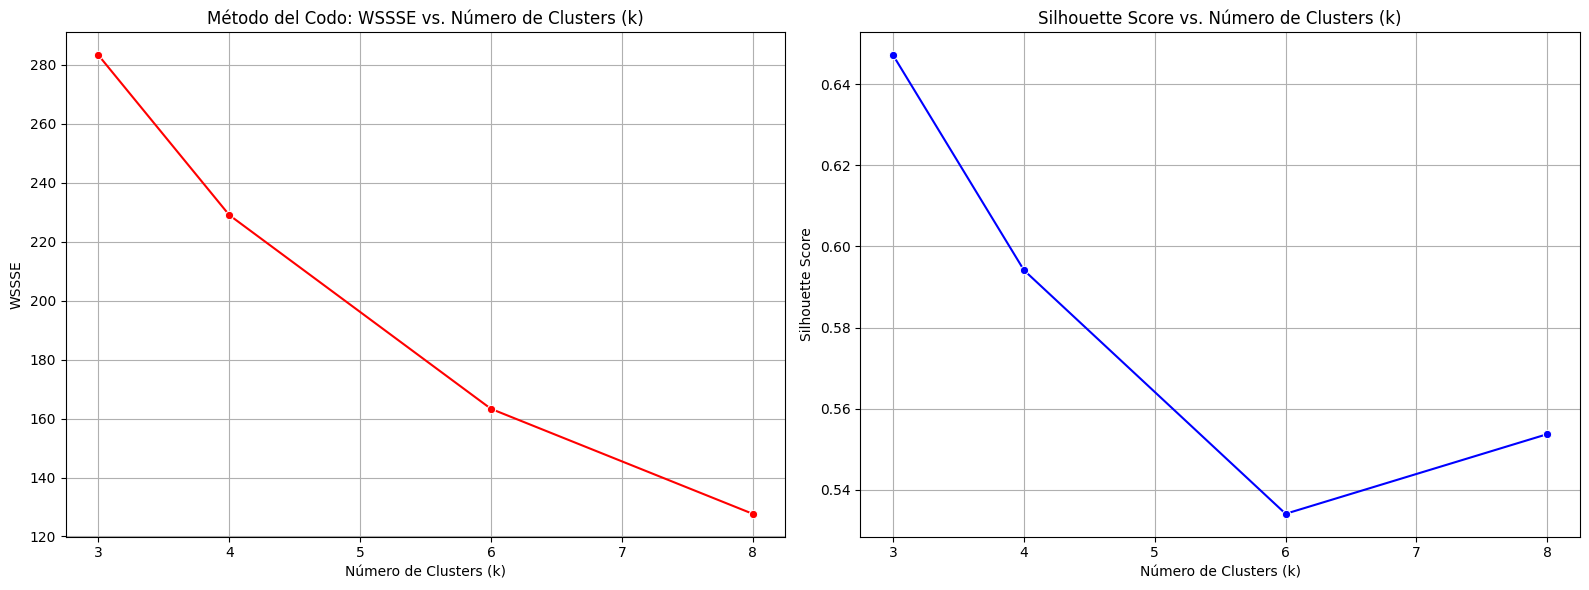

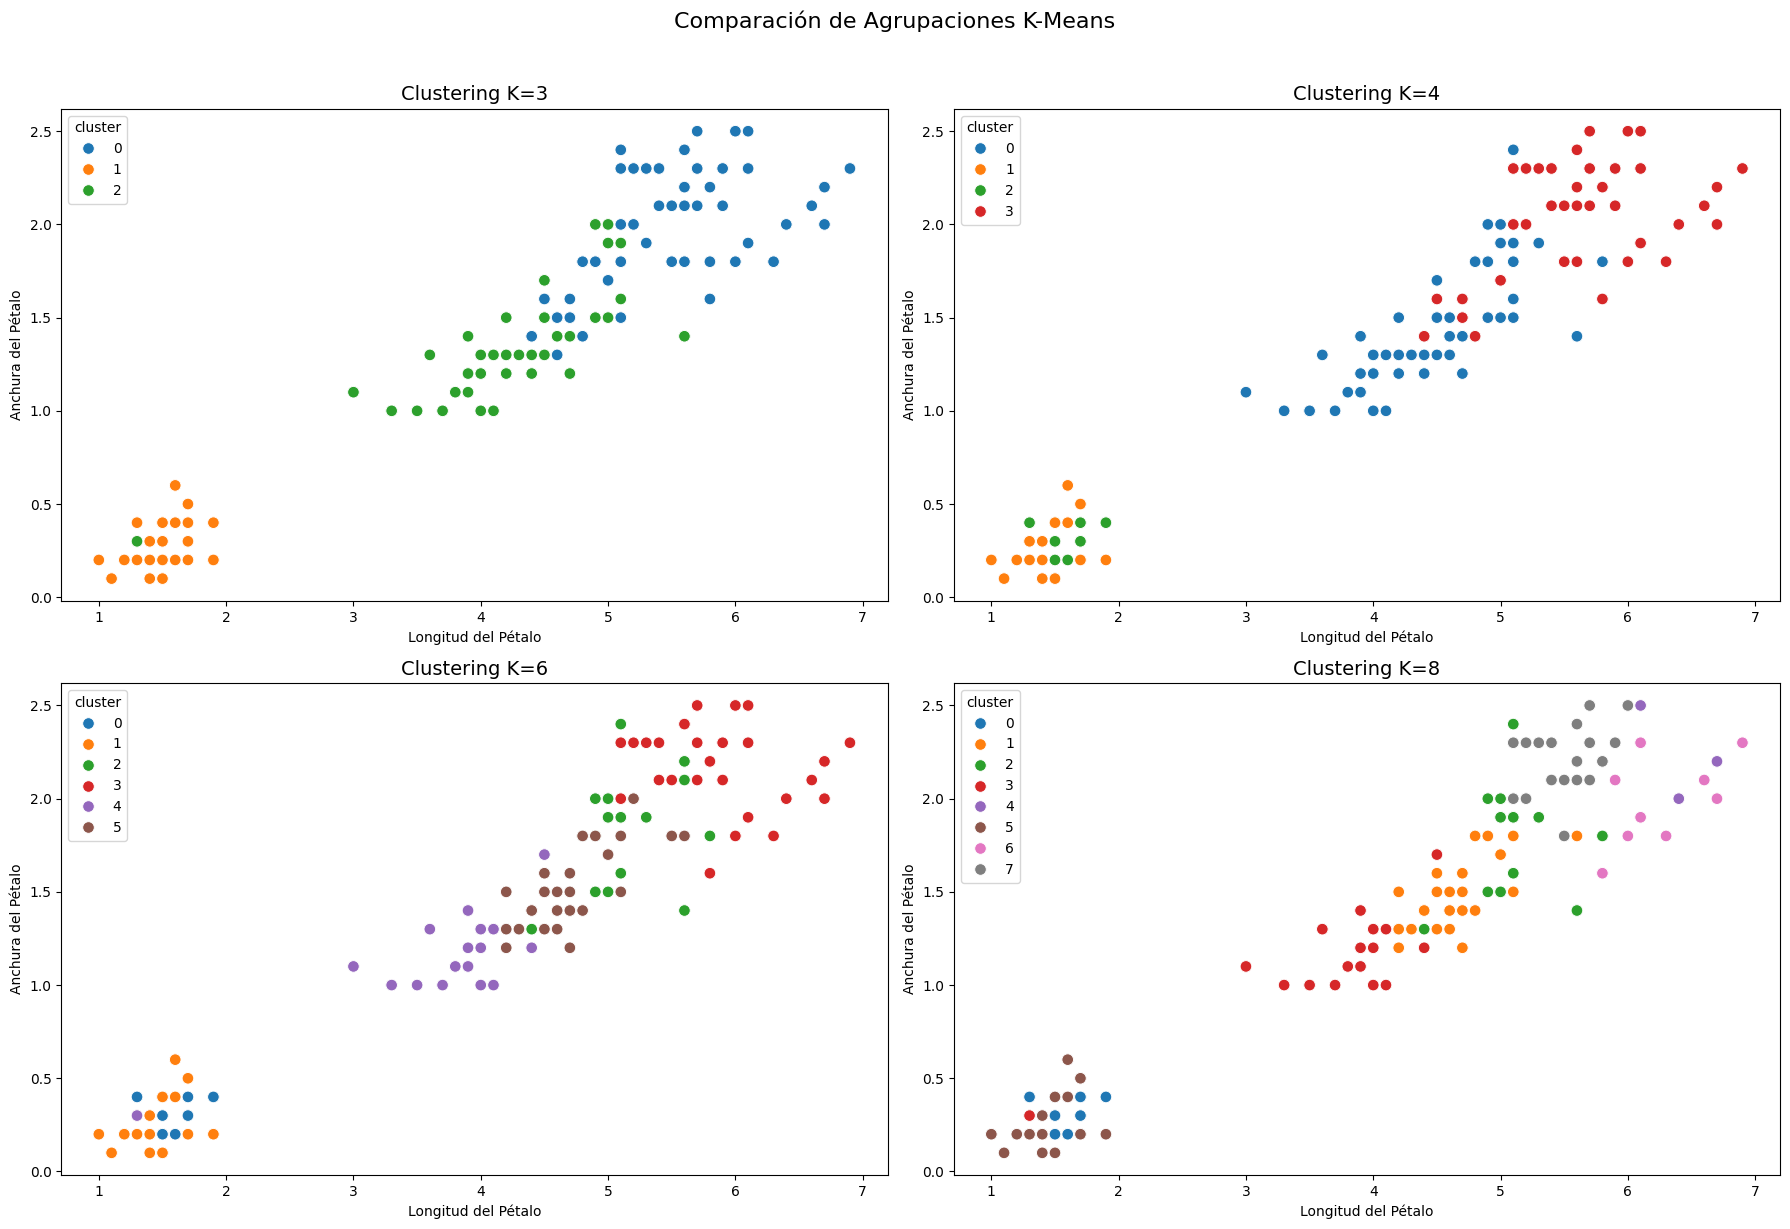

In [895]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Visualización de las Métricas (Elbow Method y Silhouette) ---

plt.figure(figsize=(16, 6))

# Gráfico WSSSE (Método del Codo)
plt.subplot(1, 2, 1)
sns.lineplot(x='k', y='WSSSE', data=df_results, marker='o', color='red')
plt.title('Método del Codo: WSSSE vs. Número de Clusters (k)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WSSSE')
plt.grid(True)

# Gráfico Silhouette Score
plt.subplot(1, 2, 2)
sns.lineplot(x='k', y='Silhouette Score', data=df_results, marker='o', color='blue')
plt.title('Silhouette Score vs. Número de Clusters (k)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# --- 2. Visualización de los Clústeres (Scatter Plots para k=3, 4, 6, 8) ---

k_to_plot = [3, 4, 6, 8] 
plt.figure(figsize=(18, 12))

for i, k in enumerate(k_to_plot):
    # Obtener el DataFrame del diccionario
    df_k = clusteres_data_pd.get(f"{k}") 
    
    if df_k is None:
        print(f"Advertencia: No se encontró el DataFrame para k={k} en clusteres_data_pd.")
        continue

    plt.subplot(2, 2, i + 1) # Creamos una cuadrícula de 2x2
    
    # Gráfico de Dispersión (Scatter Plot)
    sns.scatterplot(
        x='petal_length',  # Característica más discriminante (asumiendo datos Iris)
        y='petal_width',   # Característica más discriminante
        hue='cluster',     # Color por el clúster asignado
        data=df_k, 
        palette='tab10',   
        legend='full',
        s=70
    )
    
    plt.title(f'Clustering K={k}', fontsize=14)
    plt.xlabel('Longitud del Pétalo'); plt.ylabel('Anchura del Pétalo')

plt.suptitle('Comparación de Agrupaciones K-Means', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
#

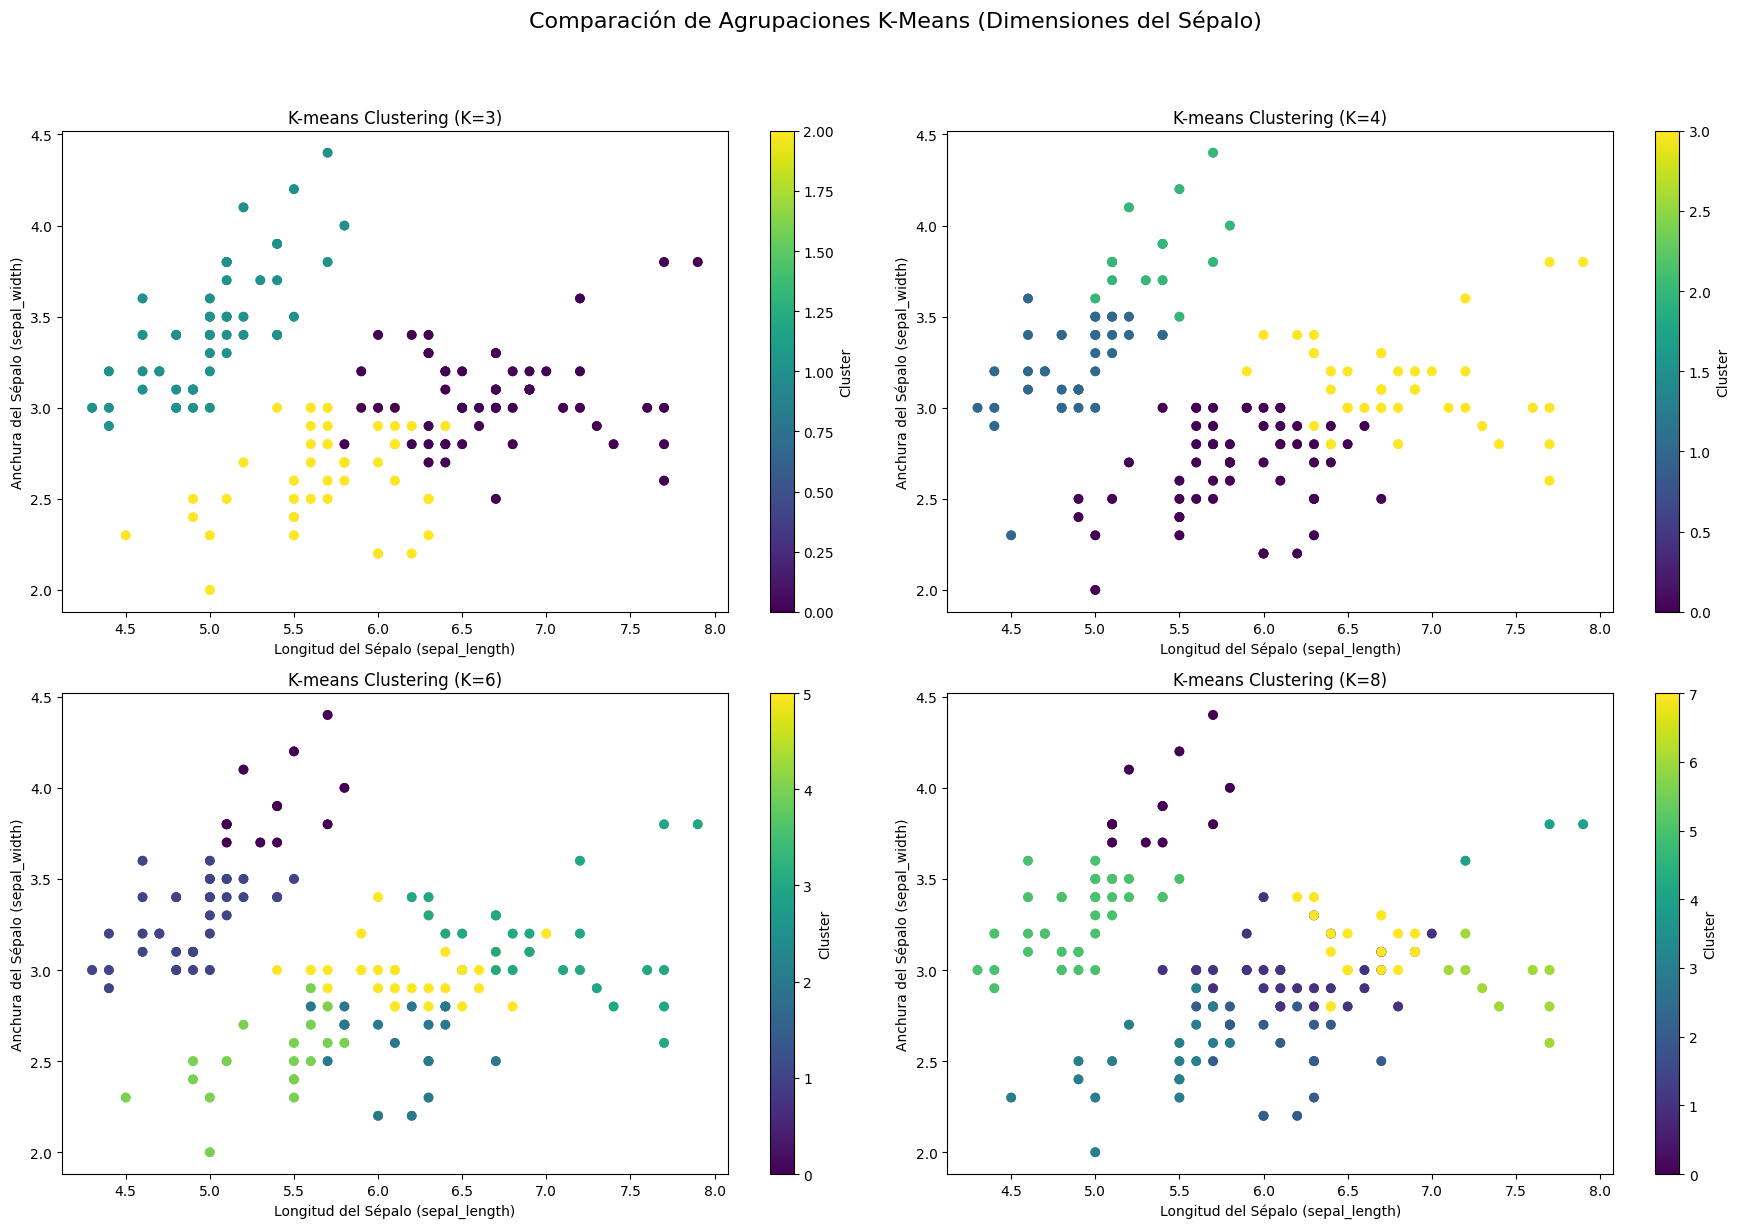

In [896]:
k_to_plot = [3, 4, 6, 8] 

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten() # Aplanamos el arreglo de ejes para poder iterar fácilmente

for i, k in enumerate(k_to_plot):
    ax = axes[i] # Selecciona el eje actual (subplot)
    df_k = clusteres_data_pd.get(f"{k}") 
    
    if df_k is None:
        print(f"Advertencia: No se encontró el DataFrame para k={k} en clusteres_data_pd.")
        continue

    # 1. Gráfico de Dispersión (Matplotlib style)
    scatter = ax.scatter(
        df_k["sepal_length"], 
        df_k["sepal_width"], 
        c=df_k["cluster"], 
        cmap='viridis' # Esquema de colores solicitado
    )
    
    # 2. Configuración de Ejes y Título
    ax.set_xlabel("Longitud del Sépalo (sepal_length)")
    ax.set_ylabel("Anchura del Sépalo (sepal_width)")
    ax.set_title(f"K-means Clustering (K={k})")
    
    # 3. Barra de Color (Colorbar)
    # Creamos la barra de color vinculada al scatter plot actual
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label("Cluster")

# Título general de la figura
plt.suptitle('Comparación de Agrupaciones K-Means (Dimensiones del Sépalo)', fontsize=16, y=1.02)

# Ajustar el layout para evitar solapamientos
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()
#

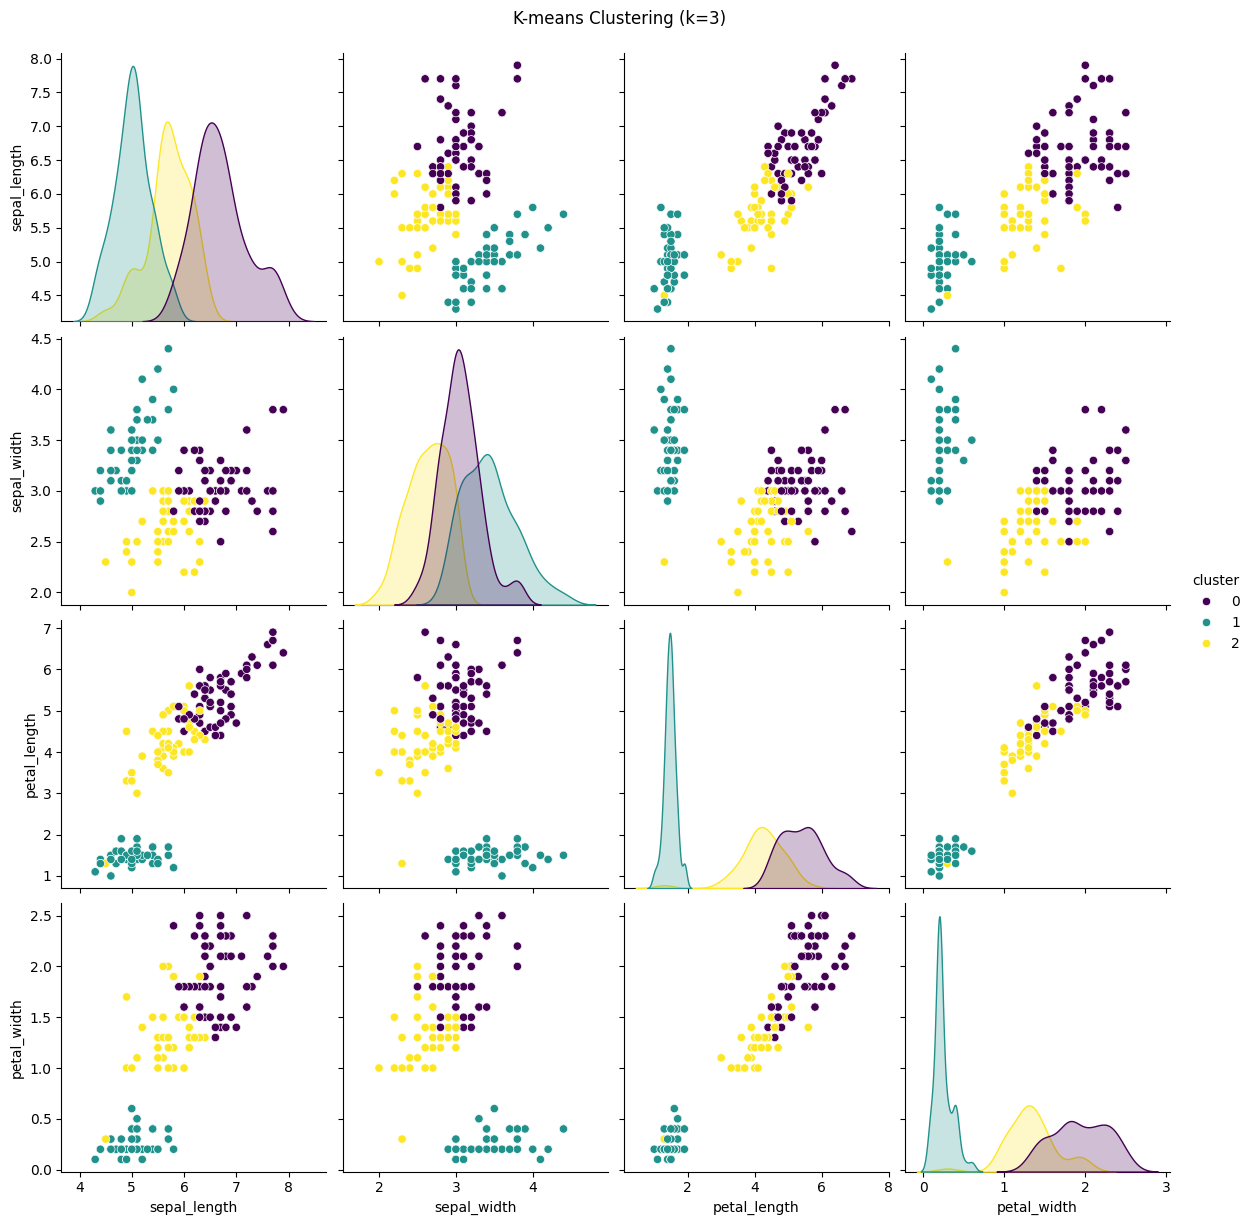

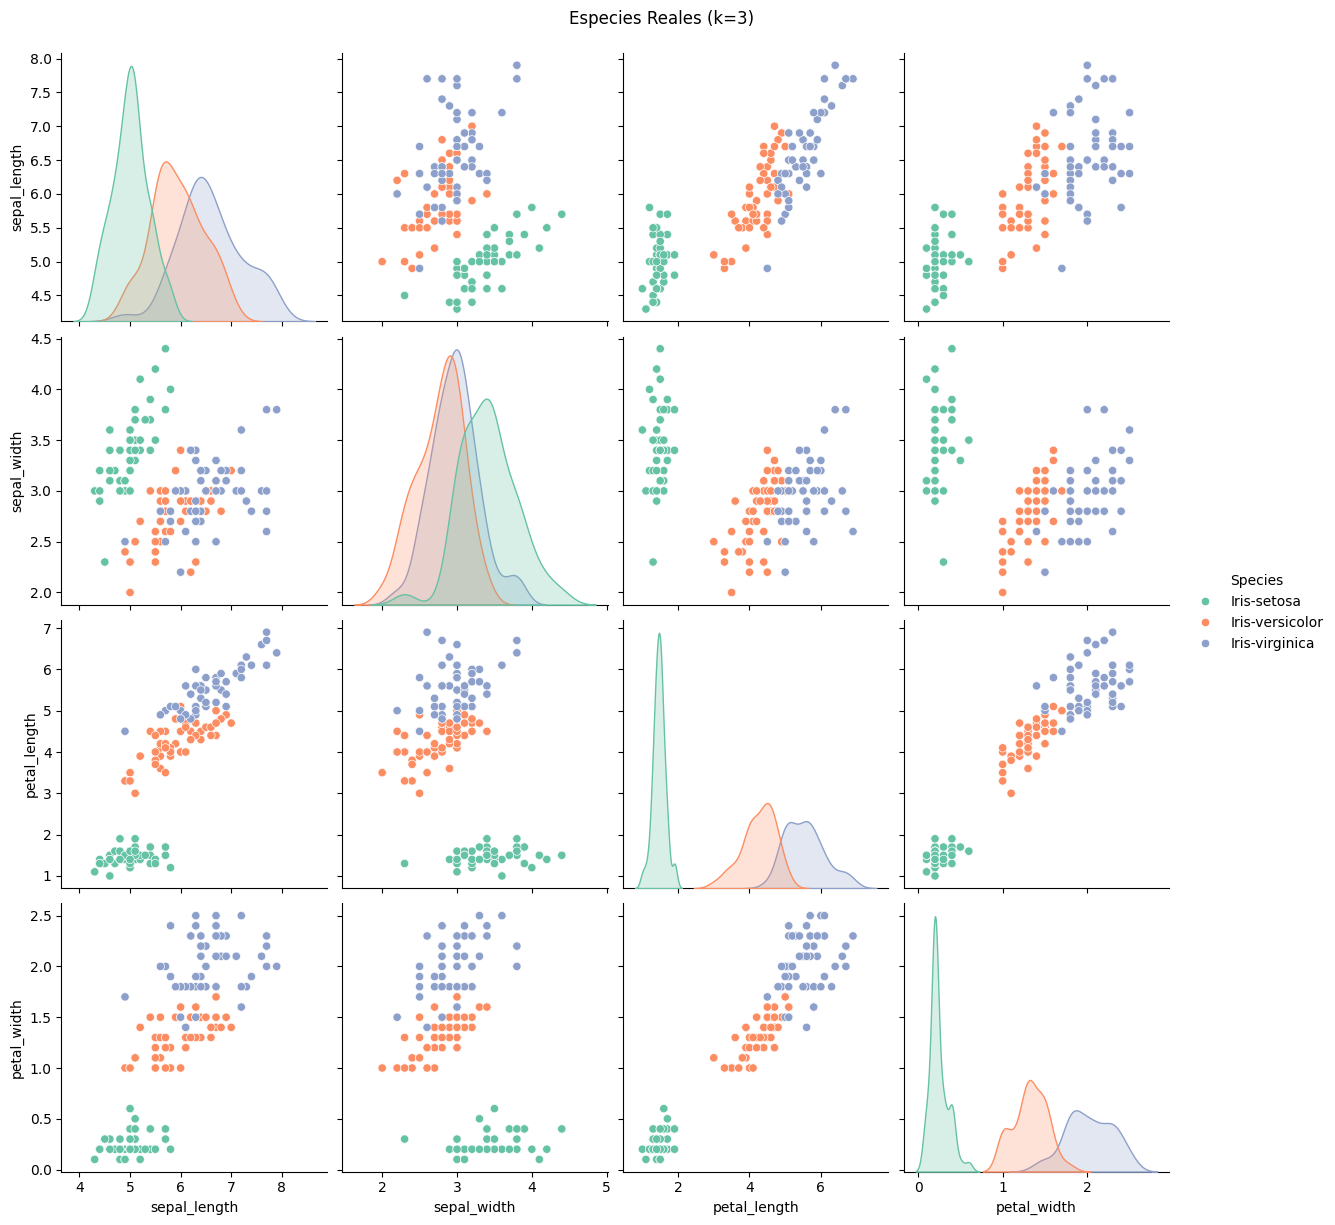

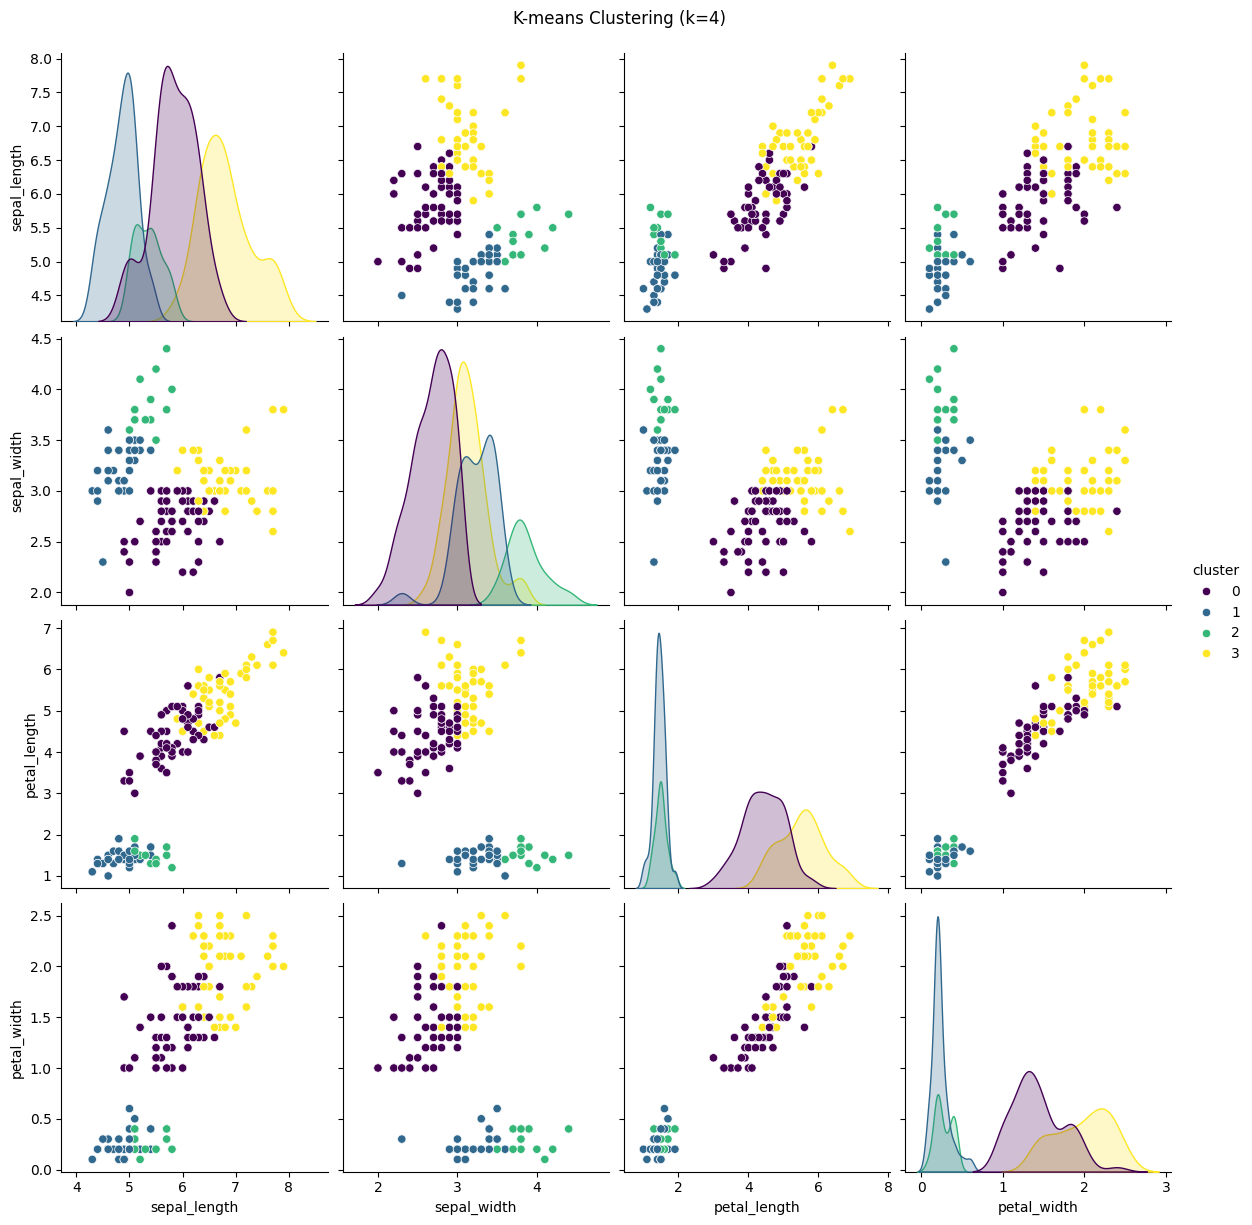

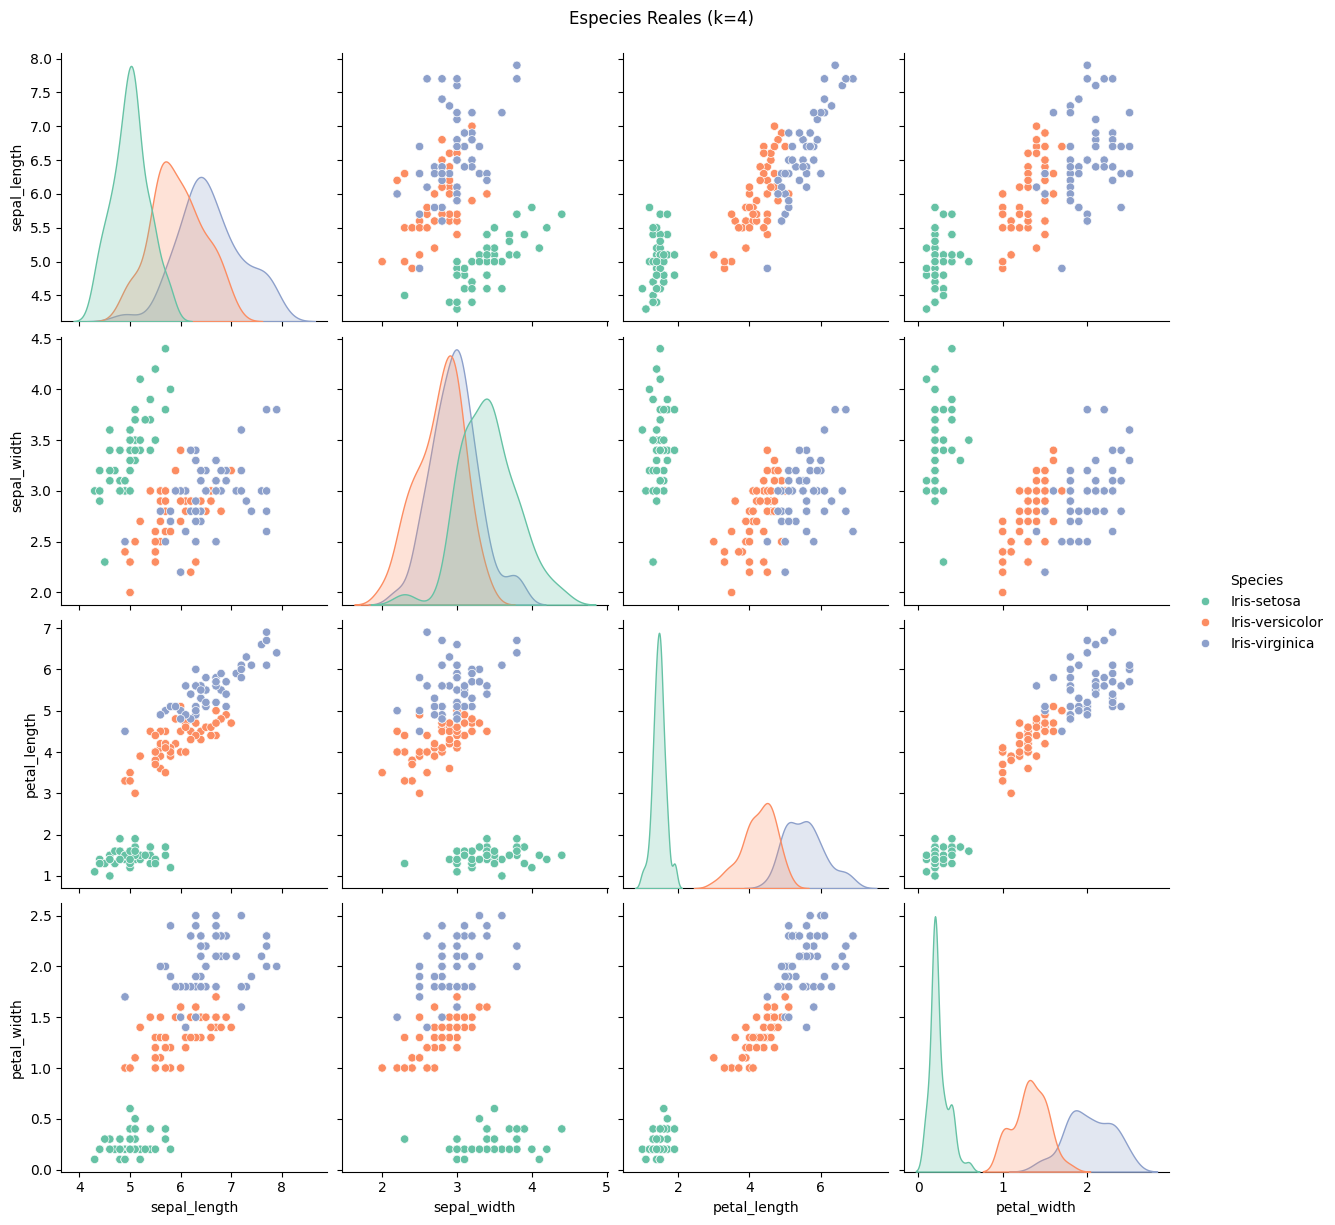

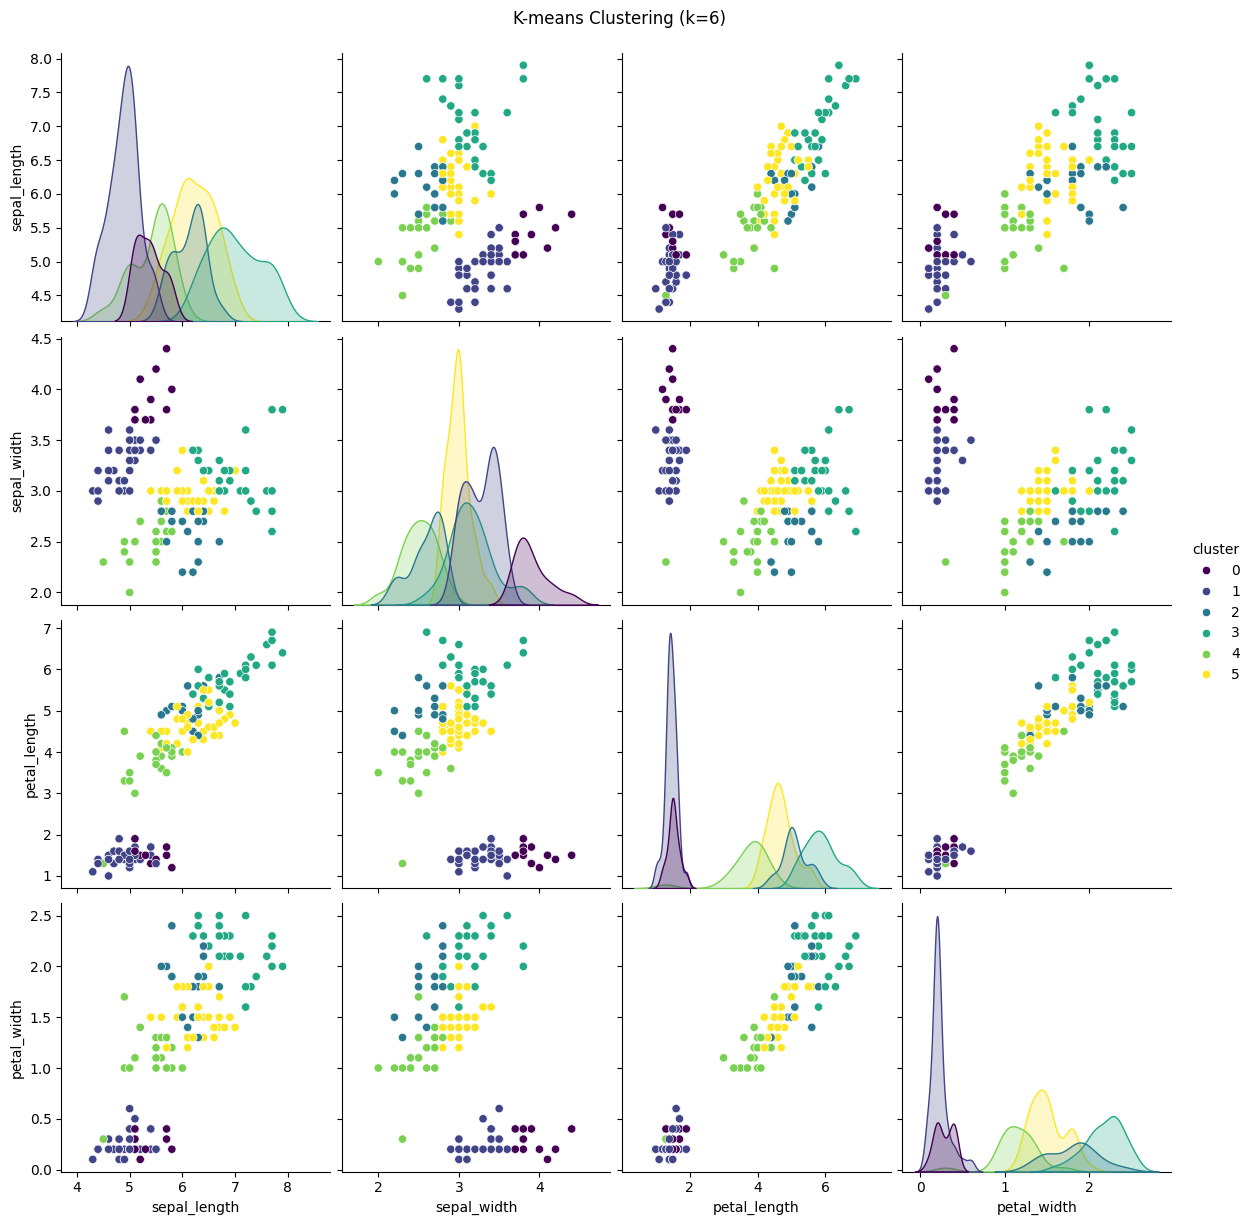

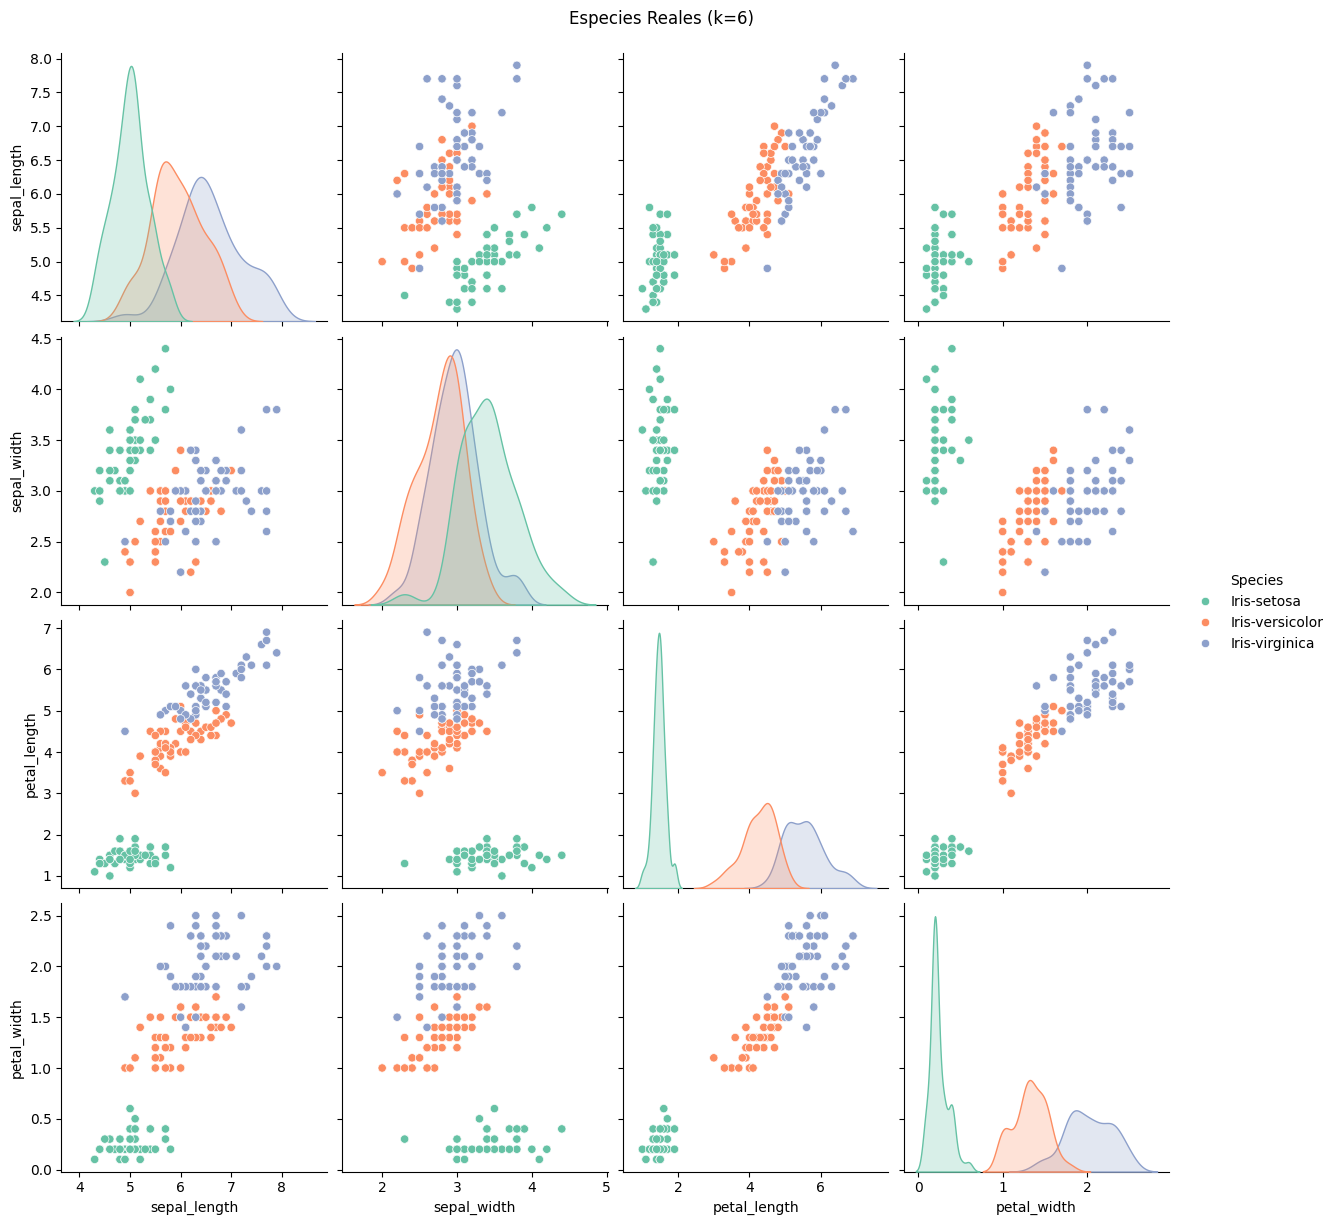

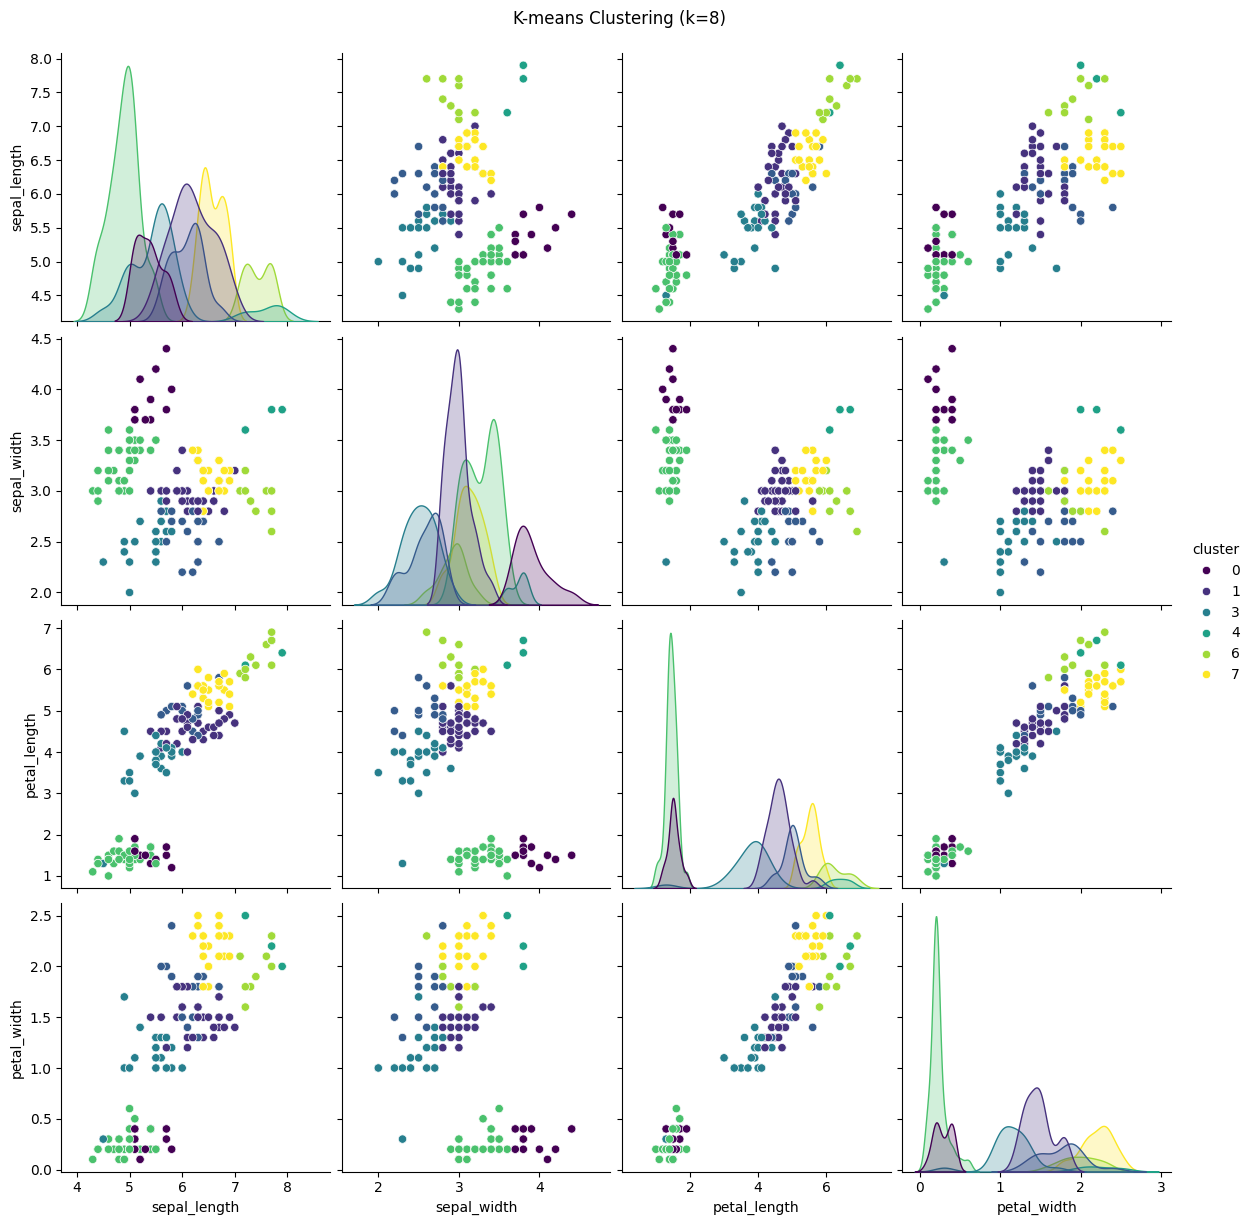

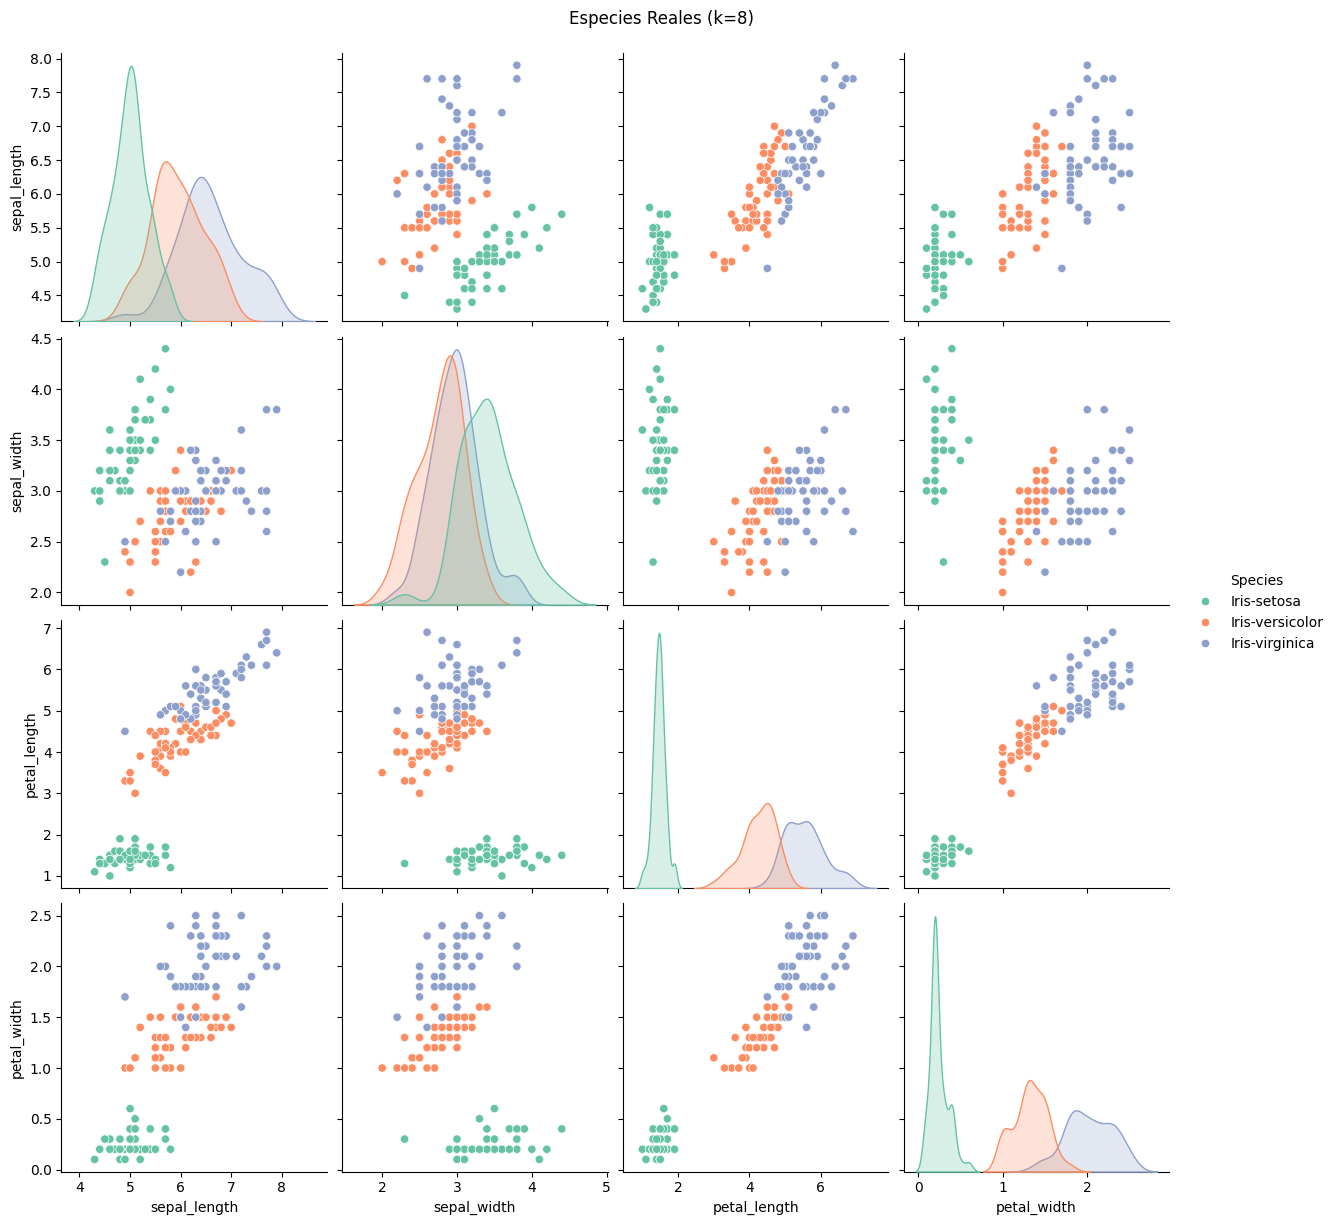

In [897]:
k_to_plot = [3, 4, 6, 8]
features = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

for k in k_to_plot:
    df_k = clusteres_data_pd.get(f"{k}")
    if df_k is None:
        print(f"Advertencia: No se encontró el DataFrame para k={k}.")
        continue

    # --- Pairplot coloreado por CLUSTER ---
    g1 = sns.pairplot(
        df_k,
        vars=features,
        hue='cluster',
        palette='viridis',
        diag_kind='kde',
        height=3
    )
    g1.fig.suptitle(f"K-means Clustering (k={k})", y=1.02)
    plt.show()

    # --- Pairplot coloreado por ESPECIE REAL ---
    if 'Species' in df_k.columns:
        g2 = sns.pairplot(
            df_k,
            vars=features,
            hue='Species',
            palette='Set2',
            diag_kind='kde',
            height=3
        )
        g2.fig.suptitle(f"Especies Reales (k={k})", y=1.02)
        plt.show()
    else:
        print(f"Advertencia: La columna 'Species' no se encontró en el DataFrame para k={k}.")

In [898]:
df_datos.columns

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'Species',
 'features',
 'scaledFeatures']

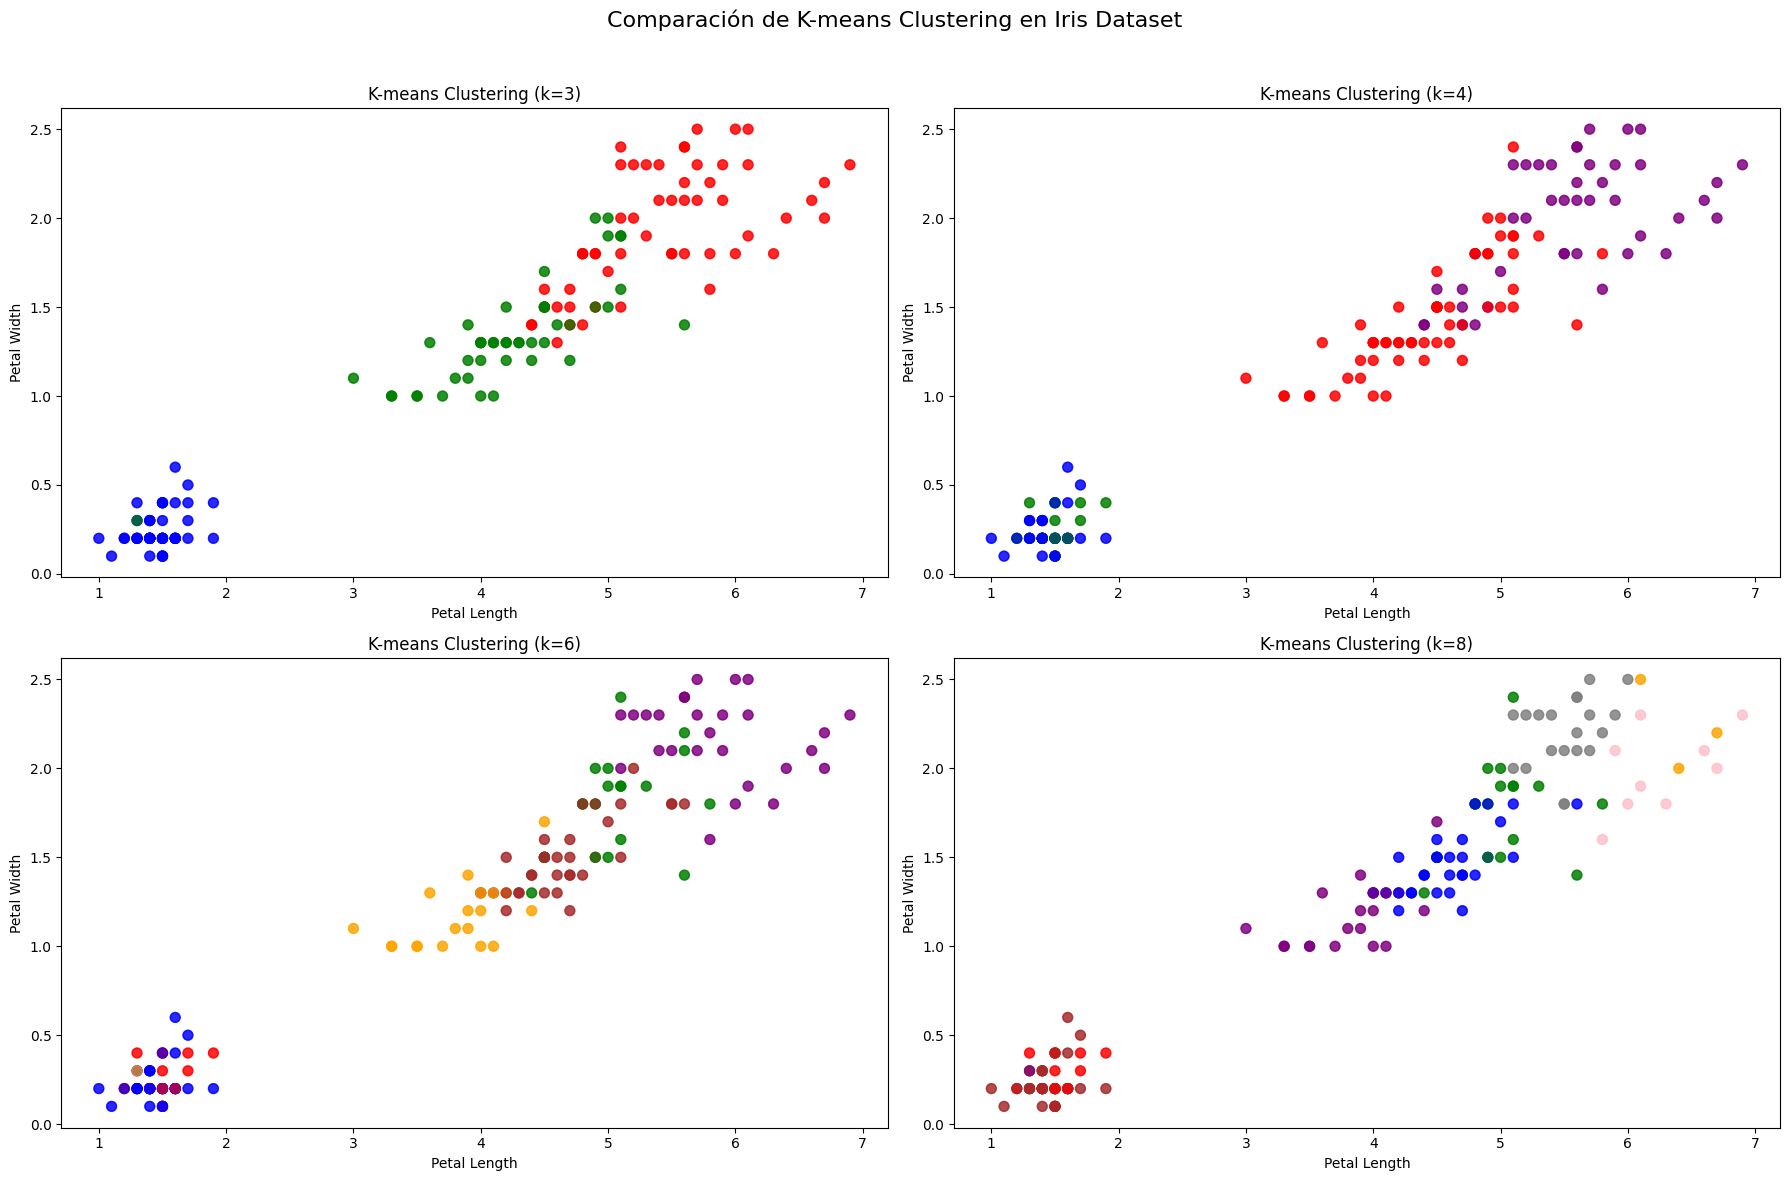

In [ ]:
k_to_plot = [3, 4, 6, 8]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()  # Aplanar el arreglo de ejes para iterar fácilmente

colors = ['red','blue','green','purple','orange','brown','pink','gray']  # Colores para hasta 8 clusters

for i, k in enumerate(k_to_plot):
    df_k = clusteres_data_pd.get(f"{k}")

    if df_k is None:
        print(f"Advertencia: No se encontró el DataFrame para k={k}.")
        continue

    ax = axes[i]

    # Asegurarse de que los valores de cluster sean enteros y válidos para indexar
    cluster_indices = df_k["cluster"].astype(int) % len(colors)

    ax.scatter(
        x=df_k["petal_length"],
        y=df_k["petal_width"],
        c=np.array(colors)[cluster_indices],
        s=50,
        alpha=0.6
    )

    ax.set_xlabel("Petal Length")
    ax.set_ylabel("Petal Width")
    ax.set_title(f"K-means Clustering (k={k})")

plt.suptitle("Comparación de K-means Clustering en Iris Dataset", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

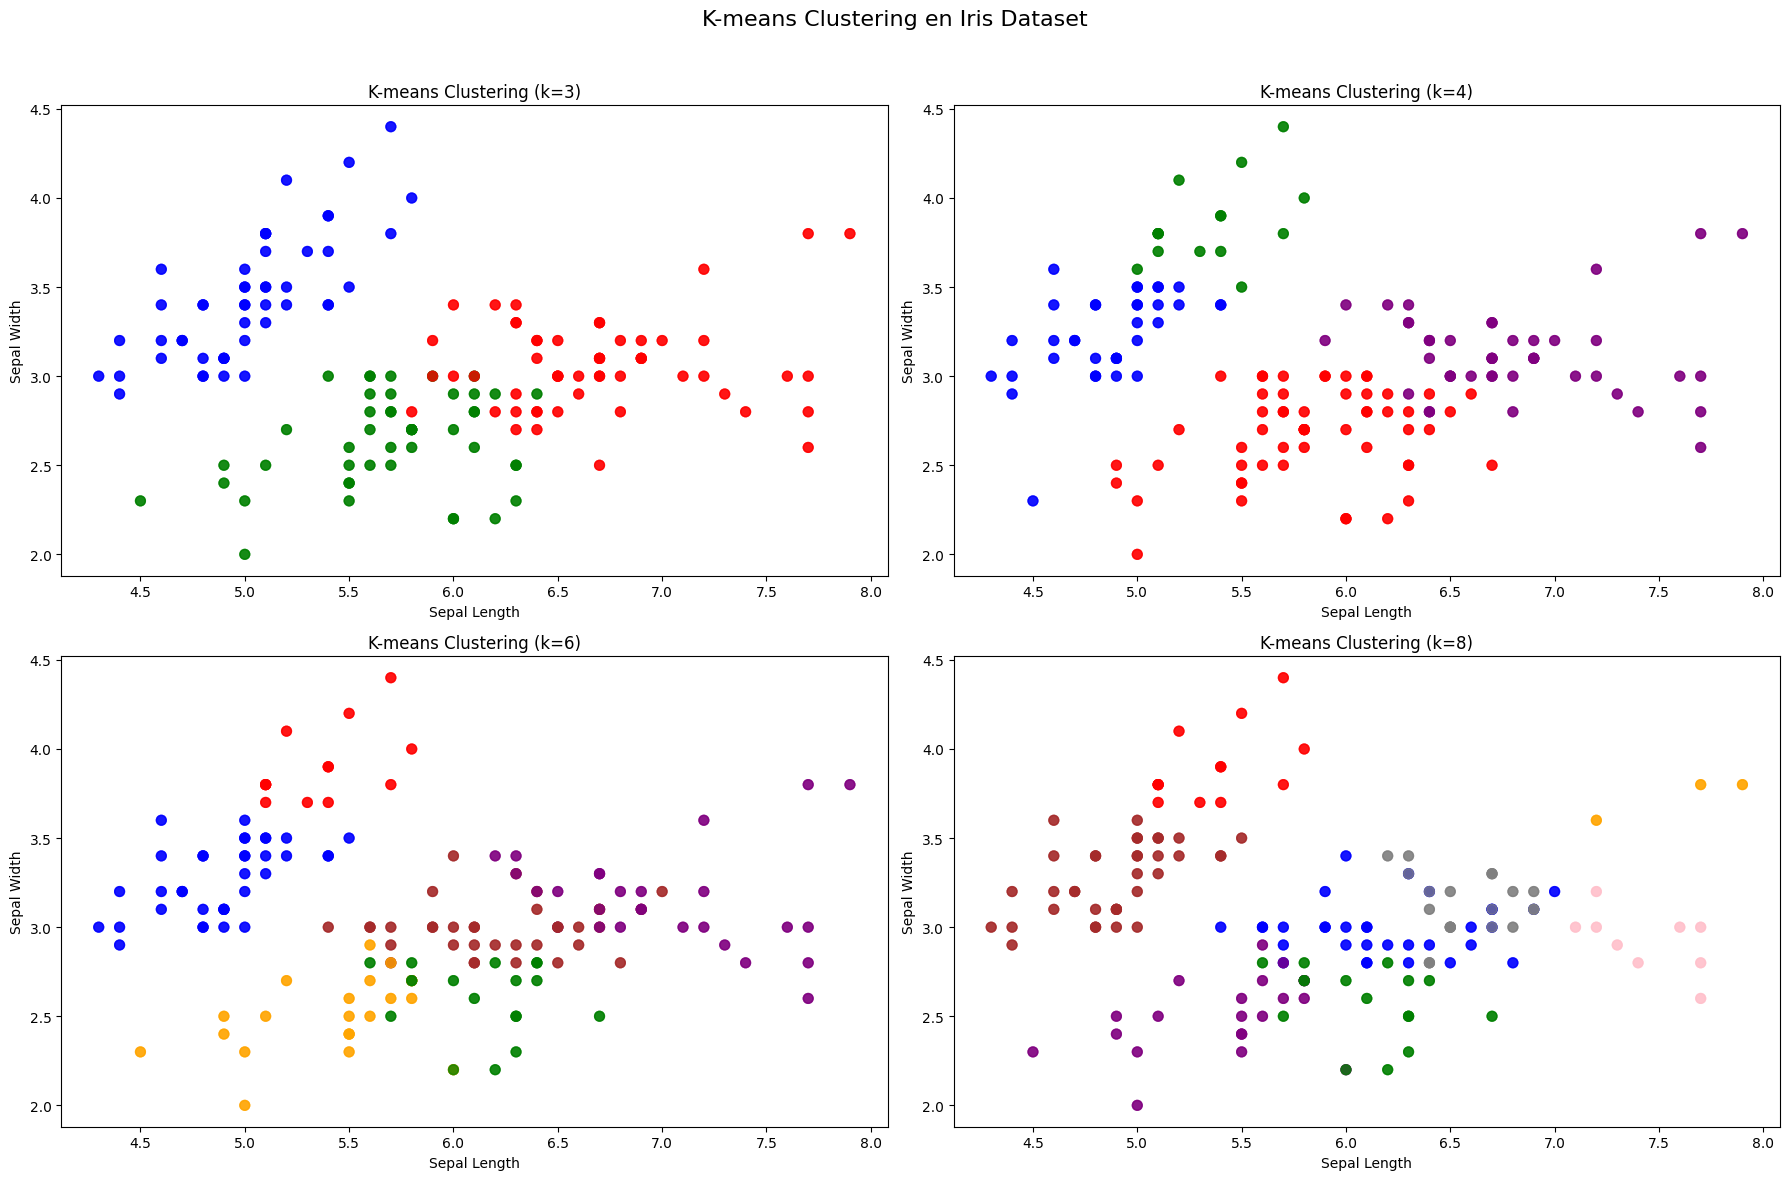

In [ ]:
k_to_plot = [3, 4, 6, 8]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()  # Aplanar el arreglo de ejes para iterar fácilmente

colors = ['red','blue','green','purple','orange','brown','pink','gray']  # Colores para hasta 8 clusters

for i, k in enumerate(k_to_plot):
    df_k = clusteres_data_pd.get(f"{k}")

    if df_k is None:
        print(f"Advertencia: No se encontró el DataFrame para k={k}.")
        continue

    ax = axes[i]
    cluster_indices = df_k["cluster"].astype(int) % len(colors)

    ax.scatter(
        x=df_k["sepal_length"],
        y=df_k["sepal_width"],
        c=np.array(colors)[cluster_indices],
        s=50,
        alpha=0.7
    )
    ax.set_xlabel("Sepal Length")
    ax.set_ylabel("Sepal Width")
    ax.set_title(f"K-means Clustering (k={k})")

plt.suptitle("K-means Clustering en Iris Dataset", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

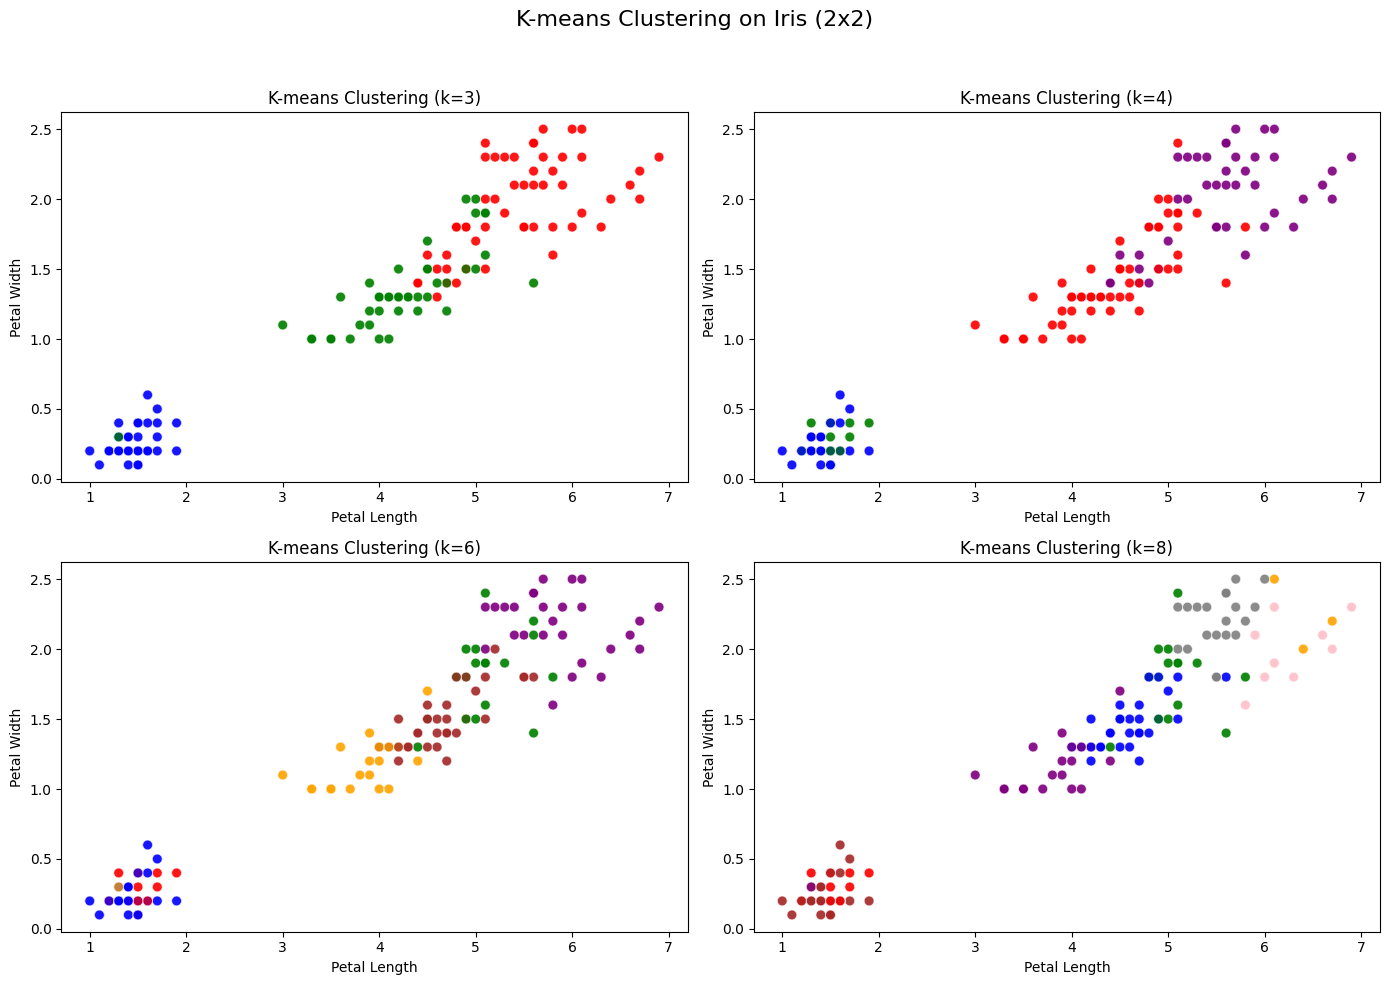

In [915]:
k_to_plot = [3, 4, 6, 8]  # Por ejemplo, diferentes k si tienes varios DataFrames
colors = ['red','blue','green','purple','orange','brown','pink','gray']  # Hasta 8 clusters

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, k in enumerate(k_to_plot):
    # Aquí supongo que tienes un diccionario de DataFrames para cada k
    df_k = clusteres_data_pd.get(f"{k}")  # o clusteres_data_pd.get(f"{k}") si tienes varios
    ax = axes[i]
    df_k['Clus_km'] = df_k['cluster']  # Asegurarse de que la columna de cluster esté presente
    cluster_indices = df_k['Clus_km'].astype(int) % len(colors)

    sns.scatterplot(
        x='petal_length',
        y='petal_width',
        data=df_k,
        hue='Clus_km',
        palette=colors,
        ax=ax,
        legend=False,
        s=50,
        alpha=0.7
    )

    ax.set_title(f"K-means Clustering (k={k})")
    ax.set_xlabel("Petal Length")
    ax.set_ylabel("Petal Width")

plt.suptitle("K-means Clustering on Iris (2x2)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
sparkDierickBrochero.stop()